\begin{equation}
Z = \sum e^{-\beta E[\{\sigma_i\}]} = \sum e^{-\beta (J \sum_{<i,j>} \sigma_i \sigma_j - h \sum_{i} \sigma_i)}
\end{equation}

\begin{equation}
-\frac{\partial}{\partial\beta} \ln Z = \sum E[\{\sigma_i\}] \frac{1}{Z} e^{-\beta E[\{\sigma_i\}]} = \left<E \right>
\end{equation}

\begin{align}
c_V &= \frac{1}{N} \frac{\partial}{\partial T} \left<E \right> = \frac{\partial \beta}{\partial T} \left( - \frac{\partial^2}{\partial\beta^2} \ln Z \right) \\
    &= \frac{1}{N T^2} \sum E[\{\sigma_i\}]^2 \frac{1}{Z} e^{-\beta E[\{\sigma_i\}]} - \frac{1}{N T^2} \sum E[\{\sigma_i\}] \frac{1}{Z} e^{-\beta E[\{\sigma_i\}]} \sum E[\{\sigma_i\}] \frac{1}{Z} e^{-\beta E[\{\sigma_i\}]} \\
    &= \frac{1}{N T^2} \left( \left<E^2 \right> - \left<E \right>^2 \right) = \frac{N}{T^2} \left( \left<\left(E/N \right)^2 \right> - \left<E/N \right>^2 \right)
\end{align}

\begin{equation}
\frac{\partial}{\partial h} \ln Z = \sum \beta \left( \sum_{i} \sigma_i \right) \frac{1}{Z} e^{-\beta (J \sum_{<i,j>} \sigma_i \sigma_j -h  \sum_{i} \sigma_i)} = \frac{1}{T} \left<M \right>
\end{equation}

\begin{align}
\chi &= \frac{1}{N} \frac{\partial}{\partial h} \left<M \right> = \frac{\partial}{\partial h} \left( T \frac{\partial}{\partial h} \ln Z \right) \\
    &= \frac{1}{NT} \sum \beta^2 \left( \sum_{i} \sigma_i \right)^2 \frac{1}{Z} e^{-\beta (J \sum_{<i,j>} \sigma_i \sigma_j -h \sum_{i} \sigma_i)} - \frac{1}{NT} \sum \beta \left( \sum_{i} \sigma_i \right) \frac{1}{Z} e^{-\beta (J \sum_{<i,j>} \sigma_i \sigma_j -h \sum_{i} \sigma_i)}  \sum \beta \left( \sum_{i} \sigma_i \right) \frac{1}{Z} e^{-\beta (J \sum_{<i,j>} \sigma_i \sigma_j -h \sum_{i} \sigma_i)} \\
    &= \frac{1}{NT} \left( \left< M^2 \right> - \left< M \right>^2 \right) = \frac{N}{T} \left( \left< m^2 \right> - \left< m \right>^2 \right)
\end{align}

In [21]:
using PyPlot
using NBInclude
@nbinclude("ising_2d_lib.ipynb")

autocorrelation_time (generic function with 1 method)

# Visualization

In [23]:
function visualize()
    figure(figsize=(10,10))

    Length = 128

    Δtime = 100

    vec_Temperature = [1.5, 2.27, 3]
    for index_Temperature = 1:length(vec_Temperature)
        Config = initialize(Length, "random")
        time = 0

        Temperature = vec_Temperature[index_Temperature]
        
        title("T = $Temperature, t = $time")
        subplot(3, 3, 0+index_Temperature)
        imshow(Config, cmap="gray")
        xticks([])
        yticks([])

        subplot(3, 3, 3+index_Temperature)
        title("T = $Temperature, t = $time")
        dynamics_tw(Config, Temperature, Δtime)
        time += Δtime
        imshow(Config, cmap="gray")
        xticks([])
        yticks([])

        subplot(3, 3, 6+index_Temperature)
        title("T = $Temperature, t = $time")
        dynamics_tw(Config, Temperature, Δtime)
        time += Δtime
        imshow(Config, cmap="gray")
        xticks([])
        yticks([])    
    end    
end

visualize (generic function with 1 method)

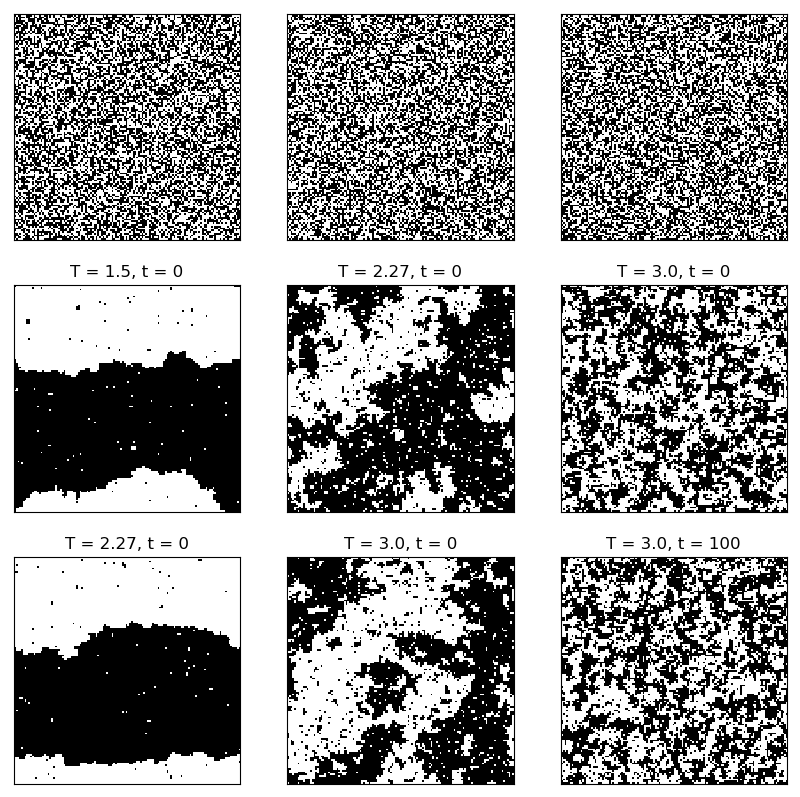

  0.281470 seconds (2.61 k allocations: 136.156 KiB)


In [25]:
@time visualize()

# Thermalization

In [18]:
function plot_magnetization()
    Length = 16

    Temperature = 2.0
    num_sample = 100
    num_sample_burn = 0
    period_sample = 1

    for iteration = 1:10
        Config = initialize(Length, "random")
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
        plot(vec_magnetization./Length./Length)
    end
end

plot_magnetization (generic function with 1 method)

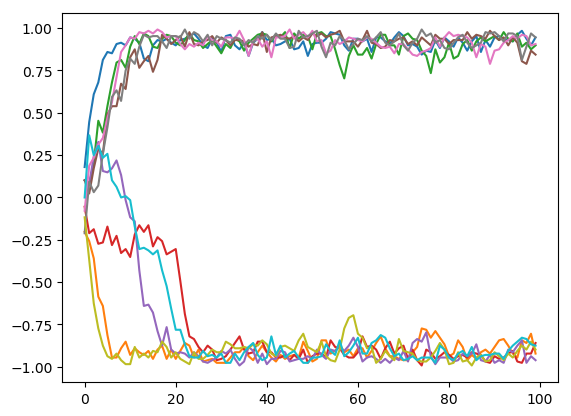

  0.043156 seconds (565 allocations: 49.297 KiB)


In [21]:
@time plot_magnetization()

# Autocorrelation

## Autocorrelation function graph

In [ ]:
function plot_autocorrelation_function()
    Length = 32
    Config = initialize(Length, "random")

    Temperature = 2.3
    num_sample = Int(1e5)
    num_sample_burn = 2000
    period_sample = 1

    for iteration = 1:5
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
        semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))
    end

    ylim([exp(-5), 1])
    yticks([1, exp(-1), exp(-2), exp(-3), exp(-4), exp(-5)],["1", L"$1/e$", L"$1/e^2$", L"$1/e^3$", L"$1/e^4$", L"$1/e^5$"])
    grid()
end

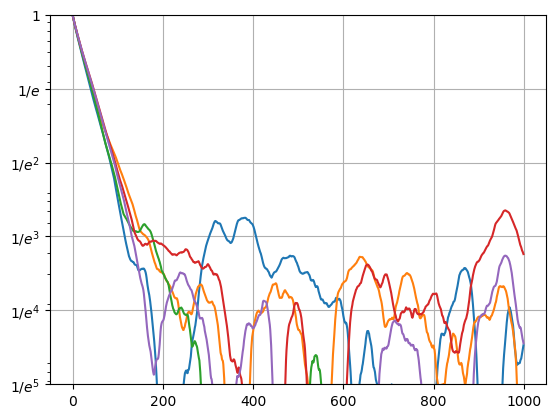

 13.251825 seconds (20.55 k allocations: 12.189 MiB, 0.05% gc time)


In [22]:
@time plot_autocorrelation_function()

Autocorrelation function of various methods

In [31]:
function compare_autocorrelation_function()
    Length = 32
    Config = initialize(Length, "random")

    Temperature = 2.27
    num_sample = Int(1e6)
    num_sample_burn = 2000
    period_sample = 1

    vec_magnetization, vec_energy = @time stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_glauber_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    vec_magnetization, vec_energy = @time stream_glauber_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)
    semilogy(autocorrelation_function(abs.(vec_magnetization), 1000))

    yticks([1, exp(-1), exp(-2), exp(-3)],["1", L"$1/e$", L"$1/e^2$", L"$1/e^3$"])
    ylim([exp(-3), 1])
    grid()

    xlabel("Time")
    ylabel("Autocorrelation")
    legend(["Metropolis, Typewriter", "Metropolis, Ranom-site", "Glauber, Typewriter", "Glauber, Random-site"])
end

compare_autocorrelation_function (generic function with 1 method)

 23.981771 seconds (9 allocations: 15.259 MiB, 0.47% gc time)
117.978073 seconds (9 allocations: 15.259 MiB, 0.00% gc time)
 67.018513 seconds (5 allocations: 15.259 MiB, 0.01% gc time)


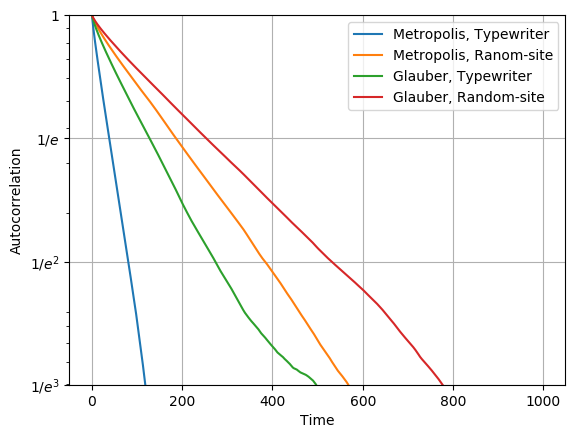

164.966275 seconds (5 allocations: 15.259 MiB, 0.00% gc time)


PyObject <matplotlib.legend.Legend object at 0x00000000019DBAC8>

In [32]:
compare_autocorrelation_function()

## Correlation time

Codes below saves correlation time data in "./data/correlation_time_...". See **data_analysis.ipynb** for plots and analysis.

In [19]:
function calc_correlation_time_tw(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = Int(1e6)
    num_sample_burn = 1000
    period_sample = 1

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_tau_m = zeros(length(vec_Temperature))
    data_tau_e = zeros(length(vec_Temperature))

    file = open(@sprintf("data/correlation_time_tw_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        vec_magnetization, vec_energy = stream_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_tau_m[index_Temperature] = autocorrelation_time(abs.(vec_magnetization), 400)
        data_tau_e[index_Temperature] = autocorrelation_time(vec_energy, 400)    
        write(file, "$Temperature\t$(data_tau_m[index_Temperature])\t$(data_tau_e[index_Temperature])\n")
        flush(file)
    end
    close(file)
end

calc_correlation_time_tw (generic function with 1 method)

In [1]:
function calc_correlation_time_rs(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = Int(1e6)
    num_sample_burn = 1000
    period_sample = 1

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_tau_m = zeros(length(vec_Temperature))
    data_tau_e = zeros(length(vec_Temperature))

    file = open(@sprintf("data/correlation_time_rs_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        vec_magnetization, vec_energy = stream_rs(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_tau_m[index_Temperature] = autocorrelation_time(abs.(vec_magnetization), 400)
        data_tau_e[index_Temperature] = autocorrelation_time(vec_energy, 400)    
        write(file, "$Temperature\t$(data_tau_m[index_Temperature])\t$(data_tau_e[index_Temperature])\n")
        flush(file)
    end
    close(file)
end

calc_correlation_time_rs (generic function with 1 method)

In [8]:
@time calc_correlation_time_tw(16)
@time calc_correlation_time_tw(24)
@time calc_correlation_time_tw(32)
@time calc_correlation_time_tw(48)
@time calc_correlation_time_tw(64)

346.866116 seconds (379.58 k allocations: 796.386 MiB, 0.11% gc time)
560.564608 seconds (110.35 k allocations: 783.196 MiB, 0.03% gc time)
902.521117 seconds (110.35 k allocations: 783.191 MiB, 0.02% gc time)


In [30]:
@time calc_correlation_time_rs(16)
@time calc_correlation_time_rs(24)
@time calc_correlation_time_rs(32)
@time calc_correlation_time_rs(48)
@time calc_correlation_time_rs(64)

 26.955584 seconds (109.18 k allocations: 83.619 MiB, 0.12% gc time)
 51.051796 seconds (83.14 k allocations: 82.402 MiB, 0.03% gc time)
 79.338053 seconds (83.14 k allocations: 82.397 MiB, 0.03% gc time)
171.150852 seconds (83.14 k allocations: 82.387 MiB, 0.01% gc time)
300.879461 seconds (83.14 k allocations: 82.377 MiB, 0.01% gc time)


# Physical quantities

Codes below saves mean absolute magnetization, variance of magnetization, mean energy, and variance of energy data in "./data/magnetization_...". See **data_analysis.ipynb** for plots and analysis.

In [4]:
function calc_magnetization(Length::Int64)
    Config = initialize(Length, "ordered")

    num_sample = 10000
    num_sample_burn = 1000

    vec_Temperature = vcat(1.5:0.1:2.2, 2.21:0.01:2.39, 2.4:0.1:3)
    data_magnetization = zeros(length(vec_Temperature))
    data_chi = zeros(length(vec_Temperature))
    data_energy = zeros(length(vec_Temperature))
    data_cv = zeros(length(vec_Temperature))

    file = open(@sprintf("data/magnetization_L%d.txt",Length), "w")
    for index_Temperature = 1:length(vec_Temperature)
        Temperature = vec_Temperature[index_Temperature]
        if 2.1 < Temperature < 2.5
            period_sample = floor(Int, 30 * Length^2 /16/16)
        else
            period_sample = 30
        end

        magnetization, chi, energy, cv = quantity_tw(Config, Temperature, num_sample, num_sample_burn, period_sample)

        data_magnetization[index_Temperature] = magnetization /Length^2
        data_chi[index_Temperature] =  chi /Length^4
        data_energy[index_Temperature] = energy /Length^2
        data_cv[index_Temperature] =  cv /Length^4

        write(file, "$Temperature\t$(data_magnetization[index_Temperature])\t$(data_chi[index_Temperature])\t$(data_energy[index_Temperature])\t$(data_cv[index_Temperature])\n")
        flush(file)   
    end
    close(file)
end

calc_magnetization (generic function with 1 method)

In [24]:
@time calc_magnetization(16)
@time calc_magnetization(24)
@time calc_magnetization(32)
@time calc_magnetization(48)
@time calc_magnetization(64)

 41.225672 seconds (15.59 k allocations: 784.813 KiB)
150.029966 seconds (738 allocations: 43.047 KiB)
461.191463 seconds (739 allocations: 43.438 KiB)
2318.849790 seconds (290.82 k allocations: 14.443 MiB, 0.00% gc time)
6437.209584 seconds (745 allocations: 46.766 KiB)
